# Tangles in Images II
(Michael Hermann)


In this tutorial we explore another example proposing *Tangles* for **Image Segmentation**. Out [first tutorial](https://tangle-software.github.io/tangles/tutorials/Letters.html) on the topic  showed a very basic proof of concept, in this notebook we will see a more realistic example: We search for tangles in the famous painting of the *Mona Lisa*. The notebook is inspired by the paper [Tangles and the Mona Lisa](https://www.math.uni-hamburg.de/home/diestel/papers/MonaLisa.pdf). 

The purpose of this notebook is a quite pragmatic one, this means we will mainly focus on the practical application of tangles to image segmentation and will not again repeat a lot of the theory. All concepts and definitions are explained in great detail in the [book](https://tangles-book.com/book/). If you like to read more about the idea to use tangles in image processing, a look at the mentioned paper is highly recommended!


What do we need for tangle image segmentation? As mentioned in detail in the first image segmentation tutorial, we mainly need a *feature set* and an *order function* that determines the order in which the features are to be specified by the tangle search algorithm. This notebook will show an interesting case where these two things belong strongly together: We will first choose an order function - a particularly nice one: a *matrix order function* based onlixel similarity - and use a method inspired by linear algebra to find a bunch of very interesting features - the so-called *spectral separations*. Spectral methods work surprisingly well for image segmentation and, as we will see, combine neatly with tangle analysis algorithms.

## 1. The Input Image

Let's start slowly and have a look at our input image:

The next plot shows the original image on the left and a gray scale version on the right. For simplicity, we will work with the gray scale image in this notebook.

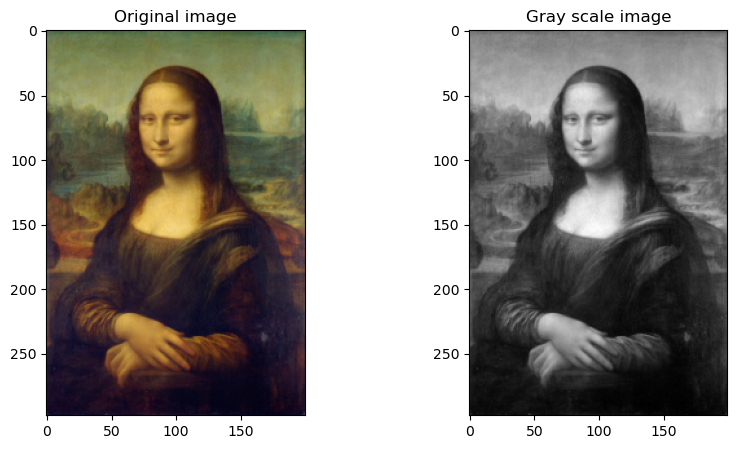

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray

org_image = io.imread("images/MonaLisa.png")
gray_image = rgb2gray(org_image)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(org_image)
axes[0].set_title("Original image")
axes[1].imshow(gray_image, cmap="gray")
axes[1].set_title("Gray scale image")
plt.show()

## 2. An Order Function Based on Point Similarity

A matrix order function is an order function $\mathcal{S} \rightarrow \mathbb{R}$ given by a *quadratic form* $s \mapsto f_s^T M f_s$ where $f_s \in \mathbb{R}^V$ is a vector representation of the feature/separation $s \in \mathcal{S}$ and $M \in \mathbb{R}^{V \times V}$ is a matrix encoding pairwise relations between our data points in $V$. A common way to find a matrix $M$ associated with the pixels of an image is to build a *Laplacian matrix* of a *similarity graph*. A similarity graph usually is a weighted graph $G_{sim} = (V,E,W)$ on the pixels $V$ with edges between pixels that are sufficiently close together such that we can assume some kind of spatial relation. The weights $W: E \rightarrow \mathbb{R}$, usually positive, encode some form of likelihood that two pixels belong to the same segment of the image. The pairwise information can be arbitrarily sophisticated and the computation might involve very complex methods from computer vision and artifical intelligence, but a very basic method works quite nicely and suits best for our example: The edge weight between two spatially close pixels is the *pixel intensity value similarity* weighted inversely by the *distance* between the pixels' location. 
The details are not very interesting here - there are multiple ways to implement such a similarity graph, the tangle library contains a useful implementation for your convenience. If you are interested in the details, please consult the documentation of the functions [grid_distance_graph](https://tangle-software.github.io/tangles/reference/api/tangles.util.graph.similarity.grid_distance_graph.html) and [image_to_similarity_graph](https://tangle-software.github.io/tangles/reference/api/tangles.util.graph.similarity.image_to_similarity_graph.html).

We first create the similarity graph. The graph is represented by its *adjacency matrix*, i.e. a matrix $A \in \mathbb{R}^{V \times V}$ containing the entry $W(u,v)$ if $uv$ is an edge and zero otherwise.  

In [2]:
from tangles.util.graph.similarity import grid_distance_graph, image_to_similarity_graph

A = image_to_similarity_graph(gray_image, grid_distance_graph(gray_image.shape, max_dist=3, normalize=True))

The edges and their weights can be visualised in a quite nice way. Such visualisations can be crucial to find meaningful parameters for the similarity computations and to debug the implementation:
(if the notebook is run in mode `matplotlib notebook`, the following plot is interactive)

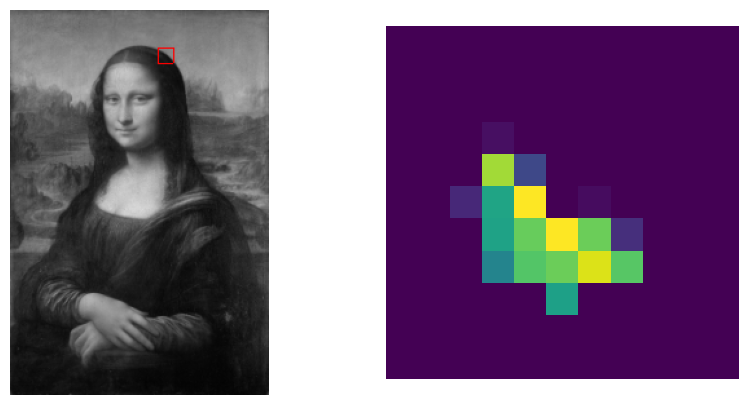

In [3]:
from tangles.util.ui import XYPicker

zoom_half_size = 5

_, axes = plt.subplots(1, 2, figsize=(10,5))

def draw_image_zoom_picker(ax, sel_xy):
    marked_im = np.repeat(gray_image[:, :, np.newaxis], 3, axis=2)
    if sel_xy is not None:
        min_y, max_y = sel_xy[1] - zoom_half_size, sel_xy[1] + zoom_half_size
        min_x, max_x = sel_xy[0] - zoom_half_size, sel_xy[0] + zoom_half_size
        marked_im[min_y - 1, min_x - 1:max_x + 1, :] = (1, 0, 0)
        marked_im[max_y + 1, min_x - 1:max_x + 1, :] = (1, 0, 0)
        marked_im[min_y - 1:max_y + 1, min_x - 1, :] = (1, 0, 0)
        marked_im[min_y - 1:max_y + 1, max_x + 1, :] = (1, 0, 0)
    ax.axis("off")
    ax.imshow(marked_im)

def update_zoom_img(sel_x, sel_y, ax):
    sel_x, sel_y = int(sel_x), int(sel_y)
    im_idx = sel_y*gray_image.shape[1]+sel_x
    min_x, max_x = sel_x - zoom_half_size, sel_x + zoom_half_size
    min_y, max_y = sel_y - zoom_half_size, sel_y + zoom_half_size
    sim_im = np.zeros((max_x-min_x+1, max_y-min_y+1))
    for i in range(min_y, max_y+1):
        for j in range(min_x, max_x+1):
            sim_im[i-min_y,j-min_x] = A[im_idx, i*gray_image.shape[1]+j]
    ax.imshow(sim_im)
    ax.axis("off")
    return sel_x, sel_y

picker = XYPicker(axes[0], update_zoom_img, [zoom_half_size + 1, gray_image.shape[0] - zoom_half_size - 2], 
                  [zoom_half_size + 1, gray_image.shape[1] - zoom_half_size - 2], 
                  draw_custom_picker=draw_image_zoom_picker)
picker.callback_object = axes[1]
picker.show(120,35,with_callback=True)

The left picture allows to select a center pixel and its neighborhood, the right picture shows the weights between the center pixel and its neighbors: yellow values encode high similarities and purple values encode low similarity (or no similarity at all).

The most natural way to obtain a meaningful matrix order function from a similarity matrix is to create a *laplacian* of the associated graph. There are different types of laplacians of a graph, conceptually simplest is the *combinatorial laplacian* $L = D-A$ with the diagonal *degree matrix* $D \in \mathbb{R}^{V \times V}$. Using this matrix, the order of a bipartition $s \in S$ is proportional to the weight of the cut induced by $s$ in this graph, i.e. for $s = (A, A^c)$ we have 
$$|s| \propto \sum_{\substack{uv \in E \\ u \in A , v \in A^c}} W(u,v)$$.

In practice, a slight variation of the combinatorial laplacian, the so called *normalized laplacian* $L_{norm} = D^{-\frac{1}{2}} L D^{-\frac{1}{2}}$, works a bit better. This laplacian implicitly puts an additional weight on each edge taking some kind of *connectivity importance* of the end vertices into account. The details are not extremely important, the basic correspondence between the order of a bipartition and the cut weight in a graph still applies.

We create the normalized laplacian `L` and a `lambda` expression implementing the order function based on this matrix `L`:

In [4]:

from tangles.util.graph import normalized_laplacian


L = normalized_laplacian(A)
order_fun = lambda S: (S * (L @ S)).sum(axis=0)

## 3. The Features

Next, we need our features. As mentioned above, we want to use *spectral features* derived from the matrix `L`. The library provides a convenience function [spectral_features](https://tangle-software.github.io/tangles/reference/api/tangles.separations.finding.spectral_features.html): 

In [5]:
from tangles.separations.finding import spectral_features
S_spec = spectral_features(L, k=19, return_eigenvectors=False)[:,1:]

To find the spectral features, the eigenvectors corresponding to the $k=19$ smallest eigenvalues are computed and for every eigenvector a feature corresponding to its positive entries is created. The first eigenvector can be discarded as its entries have constant sign. Please note, if $f \in \mathbb{R}^V$ is an eigenvector corresponding to eigenvalue $\lambda$, then $-f$ is one, too. Therefore, a single eigenvector delivers one of the two specifications of a potential feature, but we don't know which, and we don't have any reason to prefer one specification over the other.

A strict mathematical explanation of the meaningfulness of these features would distract us from the more interesting things, so we want to limit ourselves to a visual analysis of these features. Let's have a look:  

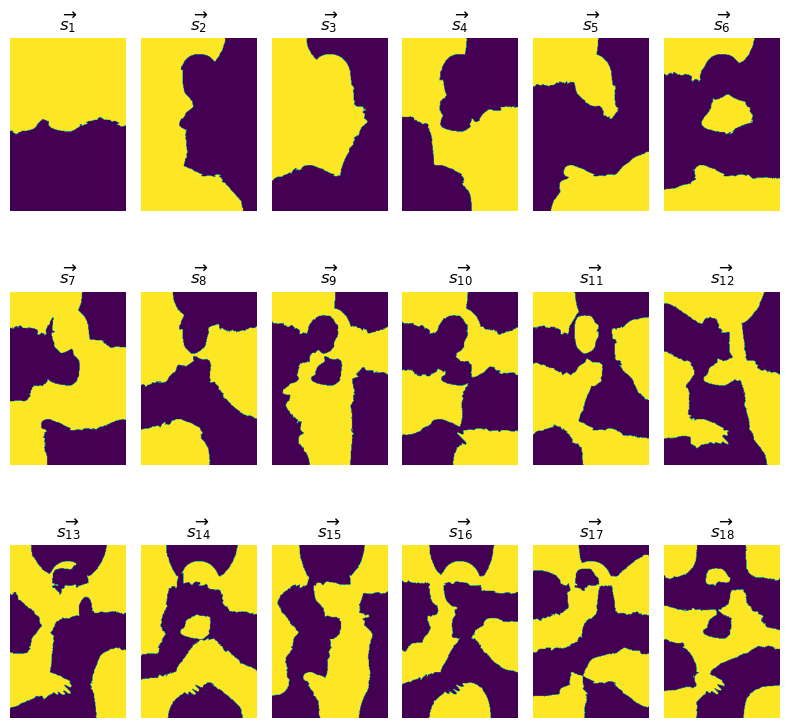

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    if i<S_spec.shape[1]:
        ax.imshow(S_spec[:,i].reshape(gray_image.shape))
        ax.axis('off')
        ax.set_title(r"$\overrightarrow{{s_{{{0}}}}}$".format(i+1))
    else:
        ax.set_visible(False)
fig.tight_layout()

We can immediately observe two facts: The complexity of the features seems to increase with the magnitude of the eigenvalues (the features are sorted by increasing eigenvalue), and each spectral feature appears to rather have a "global" than a "local" meaning. There is not a single feature that alone makes  sense to detect local structures or segments. In contrary, every feature seems to be a combination (i.e. the supremum - a logical *or*) of multiple local features. 
In the first [Image Segmentation Tutorial](https://tangle-software.github.io/tangles/tutorials/Letters.html), we proposed an interpretation of a tangle as some kind of *attention mechanism*. This interpretation is also fruitful in this example: Every tangle is a specification of these features, and we can interpret every single feature as a part of an attention mechanism. The first potential feature indicates that the attention is either on the top part or on the bottom part of the image. The second potential feature additional puts the attention either on the left part or the right part of the image. Note, that in both of these cases, the "attention border" is not simply a straight line but follows, to some extent, a region border within the image. The same applies to the higher order features but the regions of high attention are more cluttered. Nevertheless, if the "partial attentions" of the first few specifications are combined, the specification of the higher order features will further refine the region of attention. This fact illustrates that spectral features only make sense *in combination*.

Let's investigsate this fact visually. We select appropriate specifications of the first three features and compute their infimum. The combined feature  $\overrightarrow{s_1} \land \overleftarrow{s_2} \land \overrightarrow{s_3}$ looks like this:

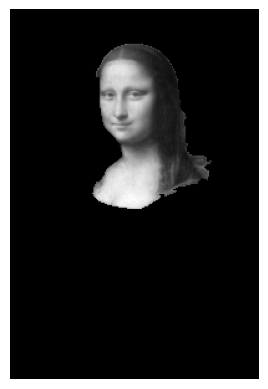

In [7]:
sup, mask = np.zeros(gray_image.shape), np.minimum.reduce([S_spec[:,0],-S_spec[:,1], S_spec[:,2]]).reshape(gray_image.shape)>0
sup[mask] = gray_image[mask]
plt.imshow(sup, cmap="gray")
plt.axis("off");

There is another important property of spectral features that has to be taken into account: The underlying eigenvectors are orthogonal, so we can not expect the derived features to be nested. Two potential features are nested if we can find specifications that are nested as sets.
This has two effects: for reasonable agreement parameter values most specifications of the first few spectral separations can be expected to be tangles, and, if we build the closure of the set of these features under the operations *inversion, supremum and infimum* we can expect to generate a significant subset of the universe of all possible features. In other words, the spectral features have *strong generative power* in the universe of all features.

The first effect is not very nice: most of the tangles of the raw feature set are *fake tangles* that would not exist if our feature system $S$ would contain more low order features betwixt the spectral features. The second effect is beneficial: if we want to build a rich feature system by extending a small set of features by their corners (and corners of corners), the set of the first few spectral features might be a very good starting point.

The problem with building corners is the number of features growing quite fast if we build corners of corners (and so on...). Therefore, it is usually a good idea to find a way to add only the corners that are really beneficial. There are a lot of heuristics to select corners, for example, we could only add *balanced* corners or only *low order* corners. These strategies can work quite well and are often worth a try, but there is an even more elegant way if our order function is *submodular*. In this case, we can resort to the theory and add the needed corners *while building the tangle search tree*. An important theorem from tangle theory states that *if we have a submodular order function on the set of all partitions $U$ of $V$, then there is a tree set of partitions $T \subseteq U$ that efficiently distinguishes all *distinguishable* tangles of $\overrightarrow U$. In other words, if we would have all partitions of $V$ with an order less than our maximum order feature in the spectral feature system $S$, than there is a (small) set of nested features that distinguishes the maximal tangles found on the extended set of features. In praxis, we usually don't have *all* features with an order below some bound, as these are way too many, therefore we extend our feature set by adding in every step only the corners needed to have a nested set of efficient distinguishers. This process is called *automatic uncrossing* and the tangle library provides convenient functions ([UncrossingSweep](https://tangle-software.github.io/tangles/reference/api/tangles.UncrossingSweep.html)) that implements the uncrossing tangle search algorithm. 

Let's create our initial feature system. We give the uncrossing algorithm a head start by computing some low order corners:

In [8]:
from tangles.convenience.convenience_features import compute_corner_features
from tangles.separations import FeatureSystem

corners, _ = compute_corner_features(S_spec, order_func=order_fun, max_order_factor=2, global_max_order=order_fun(S_spec[:,S_spec.shape[1]//3]))
orders = order_fun(corners)
corners, orders = corners[:, (sorting := orders.argsort())], orders[sorting]

If you inspect the code, you see, that we have sorted the corners by order. This is not necessary for the algorithm, but it allows us to better inspect the obtained features.The next plot shows the orders of our (sorted) features and the balance, i.e. the fraction of the data points on the smaller side of each potential feature: 

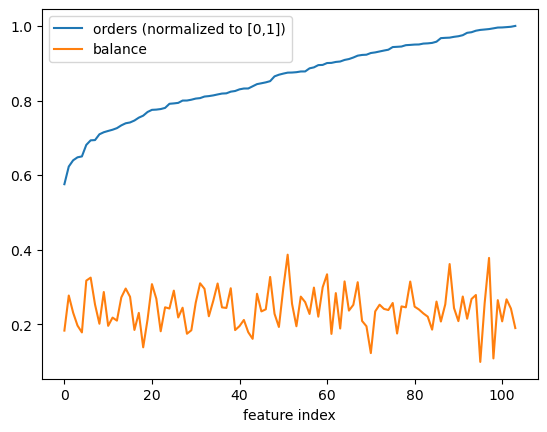

In [9]:
plt.plot(orders/max(orders), label="orders (normalized to [0,1])")
plt.plot(np.minimum((corners>0).sum(axis=0), (corners<0).sum(axis=0))/S_spec.shape[0], label="balance")
plt.xlabel("feature index")
plt.legend();

In general, submodular order functions have a tendency to prefer unbalanced features. Here, the balance seems to have no influence on the order function's value.

Let's have a look at the feature system we will use for our tangle search:

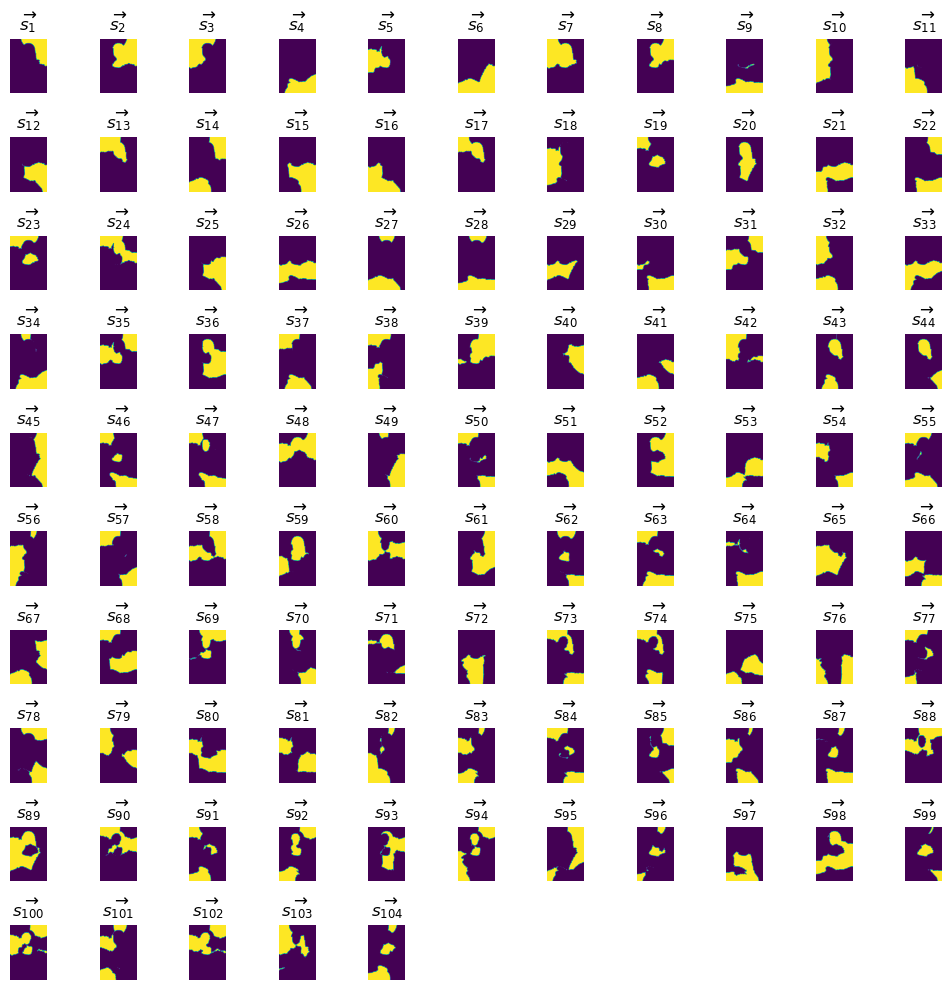

In [10]:
fig, axes = plt.subplots(nrows=10, ncols=11, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    if i<corners.shape[1]:
        ax.imshow(corners[:,i].reshape(gray_image.shape))
        ax.axis('off')
        ax.set_title(r"$\overrightarrow{{s_{{{0}}}}}$".format(i+1))
    else:
        ax.set_visible(False)
fig.tight_layout()

Most of the features still look like *compound features*, this means features that capture multiple different local aspects of the image. This is not something, a human "handcrafted" feature system would look like, but it is actually a good thing for tangles: Tangles provide a method to select good combinations of multiple (possibly complex) features!

In theory nothing prevents us from adding more corners and maybe select the most meaningful features by hand, but we are lazy and want to let the tangles do the main part of the work :-)

Let's create the separation system and go on to the tangle search...

In [11]:
sep_sys = FeatureSystem.with_array(corners)

## 4. The Tangles

We start with our initial feature system and extend it at every step of the search with the corners needed to obtain a nested set of distinguishing features. This nested set of features is usually called the *Tree of Tangles*. Our primary intention is to remove fake tangles but obtaining the tree of tangles will be a nice side effect. 

We choose a quite low agreement of `1` to remove as much fake tangles as possible (even if we will not be interested in the tangles for such a low agreement):

In [12]:
from tangles.search import UncrossingSweep
from tangles.search.progress import DefaultProgressCallback

uncrosweep = UncrossingSweep(sep_sys, order_fun)
uncrosweep.set_uncrossing_strategy_only_most_balanced_corner(False)
uncrosweep.append_next_features(agreement=1, progress_callback=DefaultProgressCallback(show_info_while_running=False));

[ tree height=914, number of tangles=1347, limit=0.0 ]: appending finished                                                                            


We started with a feature set of size `104` and scaled it up by a factor of nearly `10` by adding corners (and corners of corners (of corners...)...) to efficiently distinguish `1347` maximal tangles for an agreement parameter of `1`. This means, we are as close to the theoretical ideal situation of a complete feature system as we can get with the current implementation (and our choice of an initial feature system). 

Let us proceed to the question we are most interested in: What are tangles and what parts of the image do they describe? 
The next plot shows an excerpt of the *tangle search tree* and a visualisation of the tangles at different levels of this tree. Every tangle is drawn as a *heat map* where the intensity of each pixel indicates how much a pixel belongs to the structure the tangle points to.
We could look at all tangles for agreement `1` but these contain usually a lot of unwanted tangles. We choose an agreement parameter of `900` and look at all maximal tangles up to the level `500` in the tree:


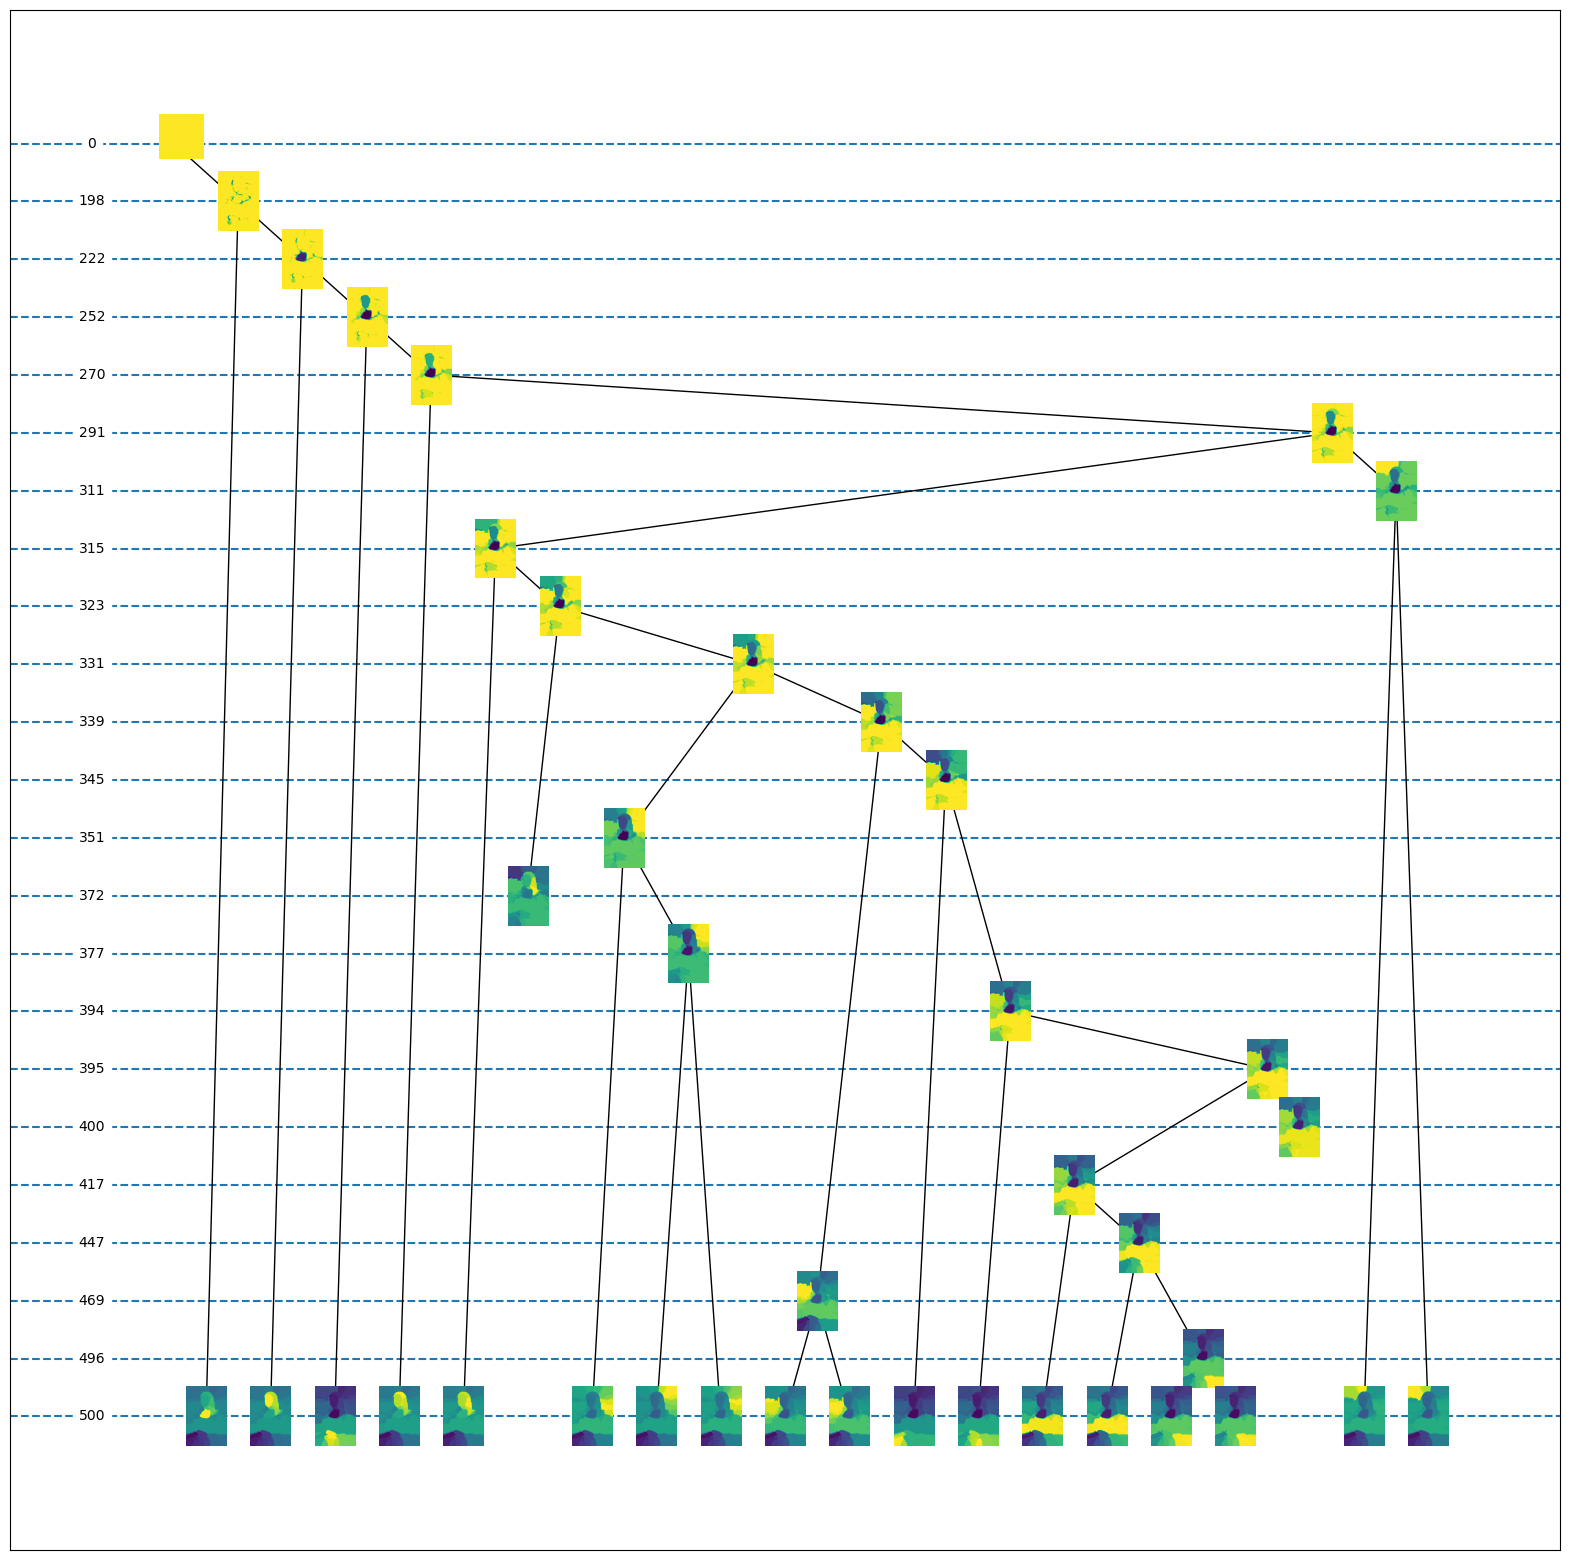

In [13]:
from tangles.analysis import tangle_score
from tangles.util.tree import BinTreeNetworkX

level = 500
agreement = 900

def draw_mona_tangle(G, node_id, ax):
    bin_tree_node = G.nodes[node_id][BinTreeNetworkX.node_attr_bin_tree_node]
    if bin_tree_node.parent is None:
        ax.imshow(gray_image, vmin=-1000, vmax=1)
    else:
        ax.set_xlim(0, gray_image.shape[1])
        ax.set_ylim(gray_image.shape[0], 0)
        path = np.array(bin_tree_node.path_from_root_indicator())[np.newaxis,:]
        scores = tangle_score(path, uncrosweep.tree.sep_ids[:path.shape[1]], uncrosweep.sep_sys, normalize_cols=True)
        ax.imshow(scores.reshape(gray_image.shape))

nodes = uncrosweep.tree.maximal_tangles(agreement=agreement, max_level=level, include_splitting='nodes')
bintree = BinTreeNetworkX(nodes)

fig, ax = plt.subplots(1,1,figsize=(20,20))
bintree.draw(draw_node_label_func=draw_mona_tangle, draw_edge_label_func=None, ax=ax, node_label_size=0.03, edge_label_size=0.015, draw_levels=True)

Interestingly, the frist detected tangles focus on the décolleté, the face and the hands. These tangles are stable until the max level, so the combination of spectral features and tangles seems to mimic a human-like attention mechanism focussing on brighter parts in the center of the image. The tangles spawned in the next levels describe the hair and a part of the ceiling. At the next splitting level the body is separated from the background and further refined into the arms and the torso. The background is split into multiple segments that correspond to more or less random brightness fluctuations in the image. It may be worth noting, that in the background the land could be separated from the ceiling, but the land part and the ceiling part can not easily be extracted from the result without looking at the details.

As stated before, the way we uncrossed our feature system allows us to get the Tree of Tangles for free. Let's visualize this tree for the same tangles as in the image above:

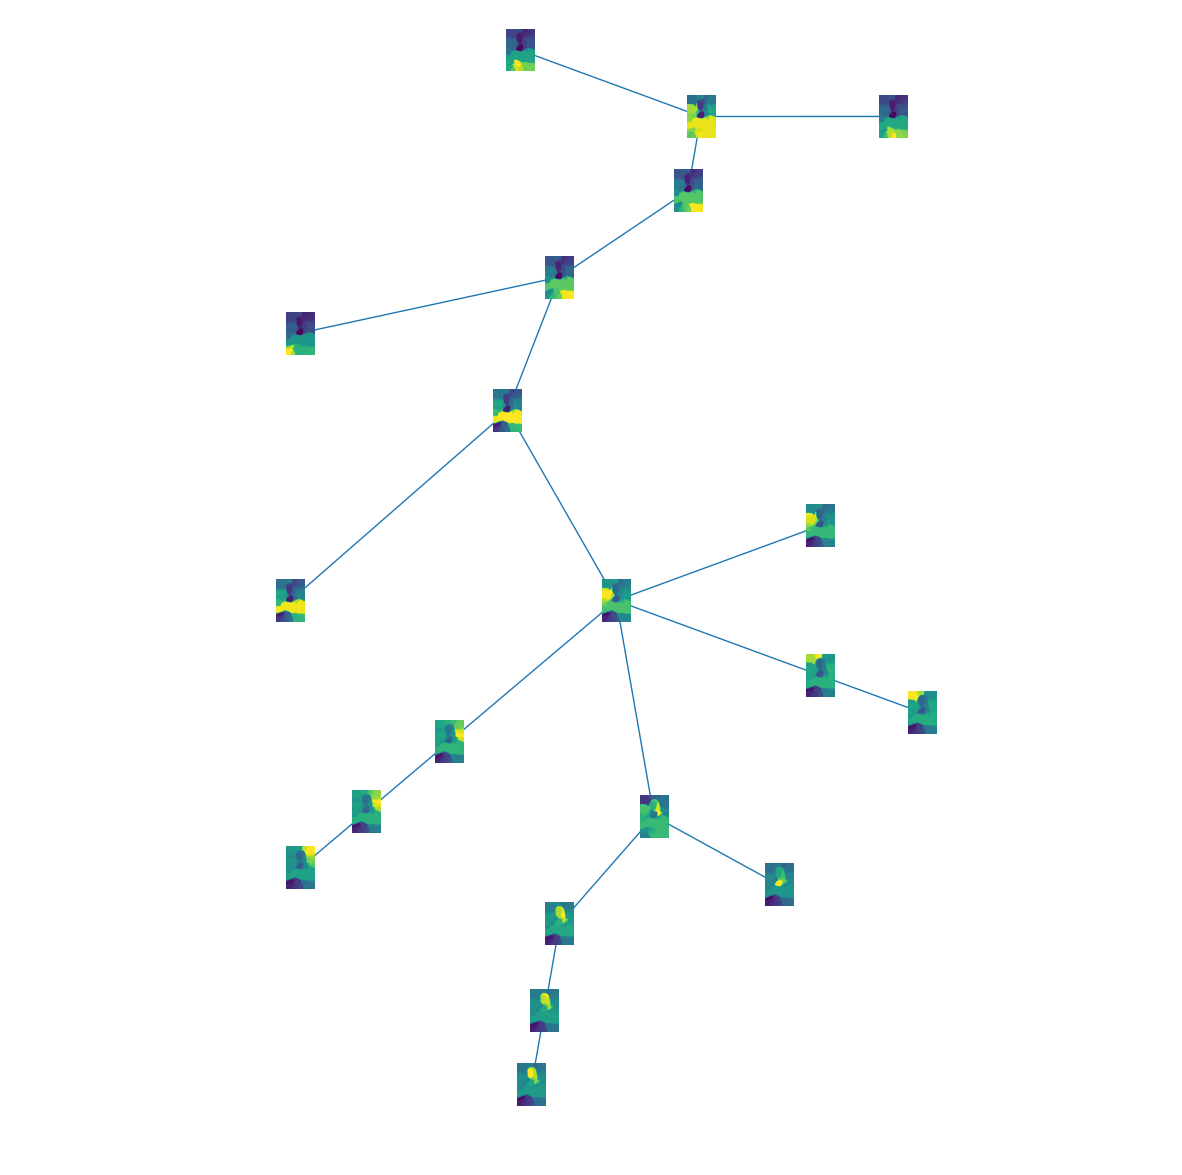

In [14]:
from tangles.util.tree import plot_tree

tot = uncrosweep.create_tot(min_agreement=agreement, max_level=level)
scores = tangle_score(tot.tangle_matrix, uncrosweep.tree.sep_ids[:tot.tangle_matrix.shape[1]], uncrosweep.sep_sys, normalize_cols=True)

def plot_tot_node(node, ax, scores, show_idx=False, show_level=False):
    ax.set_aspect('equal')
    ax.axis('off')
    ax.imshow(scores[:, node.tangle_idx].reshape(gray_image.shape))
    if show_idx:
        ax.text(0.5, 0.5, node.label, horizontalalignment='center', verticalalignment='center', color='r')
    if show_level:
        highest_dist = (node.reduced_tangle == 0).argmax() if (node.reduced_tangle == 0).any() else node.reduced_tangle.shape[0]
        ax.text(0.5, 0.5, highest_dist, horizontalalignment='center', verticalalignment='center', color='r')


plt.figure(figsize=(15, 15))
plot_tree(tot.any_node(), search_center=True, plot_node=lambda node, ax: plot_tot_node(node, ax, scores), node_size=(gray_image.shape[0] / 7000, gray_image.shape[1] / 7000));

The Tree of tangles shows the global structure of the set of tangles. In the lower part, the head is separated from the remaining image. In the middle all tangles related to the background are arranged. The top part shows all tangles related to Mona Lisa's body including the hands as a leaf at the top.

There might be a bit more tangles as one would expect in an ideal example. A promising post-processing step would be to combine some of the semantically related tangles to a single segment. Nevertheless, as we did not spend extraordinarily much time tweaking the feature system and the parameters, the result is quite pleasing. Tangles are able to provide a reasonable image segmentation result that could be used beneficially as a first step in a higher level image understanding pipeline. 